In [2]:
!git clone https://github.com/crypto-code/Hopfield-Network

Cloning into 'Hopfield-Network'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 44 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [12]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

In [3]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm

class HopfieldNetwork(object):      
    def train_weights(self, train_data):
        print("Start to train weights...")
        num_data =  len(train_data)
        self.num_neuron = train_data[0].shape[0]
        
        # initialize weights
        W = np.zeros((self.num_neuron, self.num_neuron))
        rho = np.sum([np.sum(t) for t in train_data]) / (num_data*self.num_neuron)
        
        # Hebb rule
        for i in tqdm(range(num_data)):
            t = train_data[i] - rho
            W += np.outer(t, t)
        
        # Make diagonal element of W into 0
        diagW = np.diag(np.diag(W))
        W = W - diagW
        W /= num_data
        
        self.W = W 
    
    def predict(self, data, num_iter=20, threshold=0, asyn=False):
        print("Start to predict...")
        self.num_iter = num_iter
        self.threshold = threshold
        self.asyn = asyn
        
        # Copy to avoid call by reference 
        copied_data = np.copy(data)
        
        # Define predict list
        predicted = []
        for i in tqdm(range(len(data))):
            predicted.append(self._run(copied_data[i]))
        return predicted
    
    def _run(self, init_s):
        if self.asyn==False:
            """
            Synchronous update
            """
            # Compute initial state energy
            s = init_s

            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                # Update s
                s = np.sign(self.W @ s - self.threshold)
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
        else:
            """
            Asynchronous update
            """
            # Compute initial state energy
            s = init_s
            e = self.energy(s)
            
            # Iteration
            for i in range(self.num_iter):
                for j in range(100):
                    # Select random neuron
                    idx = np.random.randint(0, self.num_neuron) 
                    # Update s
                    s[idx] = np.sign(self.W[idx].T @ s - self.threshold)
                
                # Compute new state energy
                e_new = self.energy(s)
                
                # s is converged
                if e == e_new:
                    return s
                # Update energy
                e = e_new
            return s
    
    
    def energy(self, s):
        return -0.5 * s @ self.W @ s + np.sum(s * self.threshold)

    def plot_weights(self, path):
        plt.figure(figsize=(6, 5))
        w_mat = plt.imshow(self.W, cmap=cm.coolwarm)
        plt.colorbar(w_mat)
        plt.title("Network Weights")
        plt.tight_layout()
        plt.savefig(path+"/weights.png")
        plt.show()  


Start to data preprocessing...
Start to train weights...




  0%|          | 0/589 [00:00<?, ?it/s]

  0%|          | 1/589 [00:00<09:06,  1.08it/s]

  0%|          | 2/589 [00:01<08:41,  1.13it/s]

  1%|          | 3/589 [00:02<08:24,  1.16it/s]

  1%|          | 4/589 [00:03<08:11,  1.19it/s]

  1%|          | 5/589 [00:04<08:05,  1.20it/s]

  1%|          | 6/589 [00:04<07:57,  1.22it/s]

  1%|          | 7/589 [00:05<07:52,  1.23it/s]

  1%|▏         | 8/589 [00:06<07:47,  1.24it/s]

  2%|▏         | 9/589 [00:07<07:42,  1.25it/s]

  2%|▏         | 10/589 [00:08<07:41,  1.26it/s]

  2%|▏         | 11/589 [00:08<07:39,  1.26it/s]

  2%|▏         | 12/589 [00:09<07:38,  1.26it/s]

  2%|▏         | 13/589 [00:10<07:34,  1.27it/s]

  2%|▏         | 14/589 [00:11<07:33,  1.27it/s]

  3%|▎         | 15/589 [00:12<07:32,  1.27it/s]

  3%|▎         | 16/589 [00:12<07:31,  1.27it/s]

  3%|▎         | 17/589 [00:13<07:29,  1.27it/s]

  3%|▎         | 18/589 [00:14<07:28,  1.27it/s]

  3%|▎         | 19/589 [00:15<07:28,  1.27it/s]

  3%|▎         |

Start to predict...




 25%|██▌       | 1/4 [00:04<00:14,  4.86s/it]

 50%|█████     | 2/4 [00:09<00:09,  4.78s/it]

 75%|███████▌  | 3/4 [00:13<00:04,  4.59s/it]

100%|██████████| 4/4 [00:17<00:00,  4.31s/it]


Show prediction results...


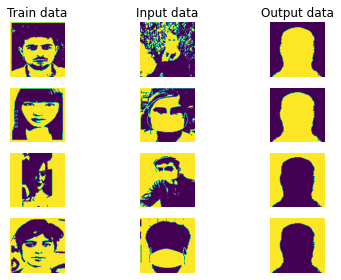

IndexError: ignored

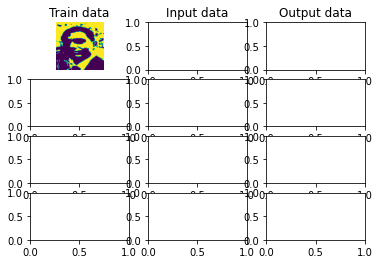

In [16]:
import numpy as np
np.random.seed(1)
from matplotlib import pyplot as plt
import skimage.data
from skimage.color import rgb2gray
from skimage.filters import threshold_mean
from skimage.transform import resize
import network
import os

# Helper Functions
def get_corrupted_input(input, corruption_level):
    corrupted = np.copy(input)
    inv = np.random.binomial(n=1, p=corruption_level, size=len(input))
    for i, v in enumerate(input):
        if inv[i]:
            corrupted[i] = -1 * v
    return corrupted

def reshape(data):
    dim = int(np.sqrt(len(data)))
    data = np.reshape(data, (dim, dim))
    return data
def split(l, n):
    for i in range(0,len(l), n):
        yield l[i:i+n]
    
def plot(data, test, predicted):
    data = [reshape(d) for d in data]
    test = [reshape(d) for d in test]
    predicted = [reshape(d) for d in predicted]
    if not os.path.exists('results_custom'):
        os.mkdir('results_custom')
    count=0
    file_count=0
    for d in split(data, 4):
        if not len(d)is 1: 
            fig, axarr = plt.subplots(len(d), 3)
            for i in range(len(d)):
                if i==0:
                    axarr[i, 0].set_title('Train data')
                    axarr[i, 1].set_title("Input data")
                    axarr[i, 2].set_title('Output data')

                axarr[i, 0].imshow(data[count])
                axarr[i, 0].axis('off')
                axarr[i, 1].imshow(test[count])
                axarr[i, 1].axis('off')
                axarr[i, 2].imshow(predicted[count])
                axarr[i, 2].axis('off')
                count = count+1

            plt.tight_layout()
            plt.savefig("results_custom/result_"+str(file_count)+".png")
            file_count=file_count+1
            plt.show()
        else:
            fig, axarr = plt.subplots(1, 3)
            axarr[0].set_title('Train data')
            axarr[1].set_title("Input data")
            axarr[2].set_title('Output data')

            axarr[0].imshow(data[count])
            axarr[0].axis('off')
            axarr[1].imshow(test[count])
            axarr[1].axis('off')
            axarr[2].imshow(predicted[count])
            axarr[2].axis('off')
            count = count+1
            plt.tight_layout()
            plt.savefig("results_custom/result_"+str(file_count)+".png")
            file_count=file_count+1
            plt.show()

def preprocessing(img, w=128, h=128):
    # Resize image
    img = resize(img, (w,h), mode='reflect')

    # Thresholding
    thresh = threshold_mean(img)
    binary = img > thresh
    shift = 2*(binary*1)-1 # Boolian to int

    # Reshape
    flatten = np.reshape(shift, (w*h))
    return flatten

def main():
    # Load data

    import cv2
    import glob
    img_dir = "/content/datas/train/without_mask" # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    data = []
    for f1 in files:
        img = rgb2gray(cv2.imread(f1))
        data.append(img)
        
    # Preprocessing
    print("Start to data preprocessing...")
    data = [preprocessing(d) for d in data]

    # Create Hopfield Network Model
    model = network.HopfieldNetwork()
    model.train_weights(data)

    # Generate testset
    img_dir = "/content/Hopfield-Network/testmask" # Enter Directory of all images 
    data_path = os.path.join(img_dir,'*g')
    files = glob.glob(data_path)
    test = []
    # Since same name order will be the same
    for f1 in files:
        img = rgb2gray(cv2.imread(f1))
        test.append(img)
    test = [preprocessing(d) for d in test]

    predicted = model.predict(test, threshold=0, asyn=False)
    print("Show prediction results...")
    plot(data, test, predicted)
    #print("Show network weights matrix...")
    #model.plot_weights("results_custom/")

if __name__ == '__main__':
    main()


In [5]:
!git clone https://github.com/prajnasb/datas

Cloning into 'datas'...
remote: Enumerating objects: 1428, done.
remote: Counting objects: 100% (1428/1428), done.
remote: Compressing objects: 100% (1428/1428), done.
remote: Total 1428 (delta 0), reused 1428 (delta 0), pack-reused 0
Receiving objects: 100% (1428/1428), 42.37 MiB | 31.17 MiB/s, done.
